In [1]:
!python -m pip install scipy

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sortedcontainers import SortedList as ost
from math import floor,ceil,log,sqrt
from collections import deque
import numpy as np
from statistics import mean,variance

In [4]:
class normal_mean :
    def __init__(self,wsize) :
        if wsize != None : wsize += 1
        self.Y = deque([0.0],maxlen = wsize)
        self.SY = deque([0.0],maxlen = wsize)
        self.SYY = deque([0.0],maxlen = wsize)
    def push(self,y) :
        self.Y.append(y)
        self.SY.append(y + self.SY[-1])
        self.SYY.append(y*y + self.SYY[-1])
        # TODO - if Y is full - normalize
    def size(self) :
        return len(self.Y) - 1
    def __call__(self,a,b) :
        val = self.SY[b+1] - self.SY[a]
        val *= val
        val /= (b - a + 1)
        val = -val
        val += self.SYY[b+1] - self.SYY[a]
        return val

In [5]:
def amoc(C,penalty) :
    c,pos = min([(C(0,C.size()-1),0)] + [(C(0,i-1) + C(i,C.size()-1),i) for i in range(1,C.size())])
    return (c + penalty,C.size() - pos - 1) if c + penalty <= C(0,C.size()-1) else  (C(0,C.size()-1),C.size()-1)

In [6]:
Z = list(np.random.normal(0, 1, 1000)) + list(np.random.normal(1, 1, 1000)) + list(np.random.normal(0, 1, 1000))
mu = mean(Z)
sigma = sqrt(variance(Z))
Z = [float((z - mu)/sigma) for z in Z]
n = len(Z)
penalty = 2*log(n)

In [7]:
C = normal_mean(len(Z))
for z in Z :
    C.push(z)

amoc(C,penalty)                                              

(2850.329851717893, 1998)

In [31]:
class cpts :
    def __init__(self,wsize) :
        self.wsize = wsize
        self.F = deque(maxlen = wsize)
    def push(self,val) :
        self.F.append(val)
        # TODO if F is full - normalize
    def __call__(self,i) :
        return self.F[i]
    def size(self) :
        return len(self.F)
    def set(self,i,val) :
        self.F[i] = val
        

In [57]:
def op(C,F,penalty) :
    class C_prime :
        nonlocal C,F
        def __call__(self,i,j) :
            if j == C.size() - 1 :
                return C(i,j)
            return F(j)[0]
        def size(self) :
            return C.size()
    F.push(amoc(C_prime(),penalty))
    shift = F(0)[0]
    for i in range(F.size()) :
        F.set(i,(F(i)[0] - shift,F(i)[1]))

    return F
        
        

In [10]:
def locations(F) :
    locs = list()
    cursor = F.size() - 1
    _,pos = F(cursor)
    while cursor - pos > 0 :
        locs.append(cursor - pos)
        cursor -= pos
        _,pos = F(cursor)
    locs.reverse()
    return locs
    

In [58]:
C = normal_mean(n)
F = cpts(n)
for z in Z :
    C.push(z)
    F = op(C,F,penalty)

In [59]:
locations(F)

[1001, 2000]

In [70]:
# wsize = n
wsize = 900
C = normal_mean(wsize)
F = cpts(wsize)
for z in Z :
    C.push(z)
    F = op(C,F,penalty)
    #G = cpts(wsize)
    #for i in range(F.size()) :
    #    G.push((F(i)[0] - F(0)[0],F(i)[1]))
    #F = G

In [71]:
locations(F)

[801]

In [74]:
import csv
data = list()
with open('test-1.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    for row in reader:
        data.append(float(row[0]))


## Test against changepoint.np

In [76]:
n = len(data)
C = normal_mean(n)
F = cpts(n)
penalty = 2*log(n)
for z in data :
    C.push(z)
    F = op(C,F,penalty)
locations(F)

[1000, 1984]

## Track the changepoint locations (no moving window)

In [77]:
n = len(data)
C = normal_mean(n)
F = cpts(n)
penalty = 2*log(n)
tracker = list()
pos = 0
for z in data :
    C.push(z)
    F = op(C,F,penalty)
    tracker.append(([pos],locations(F)))
    pos += 1

In [78]:
from itertools import cycle
from functools import reduce

In [79]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))

In [80]:
import pandas as pd

In [81]:
df = pd.DataFrame({"x" : res[0],"y" : res[1]})

In [82]:
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_point,
    theme_matplotlib,
    theme_set,
    geom_segment,
geom_vline,
xlim,
coord_cartesian
)

# Set default theme for all the plots
# theme_set(theme_matplotlib())



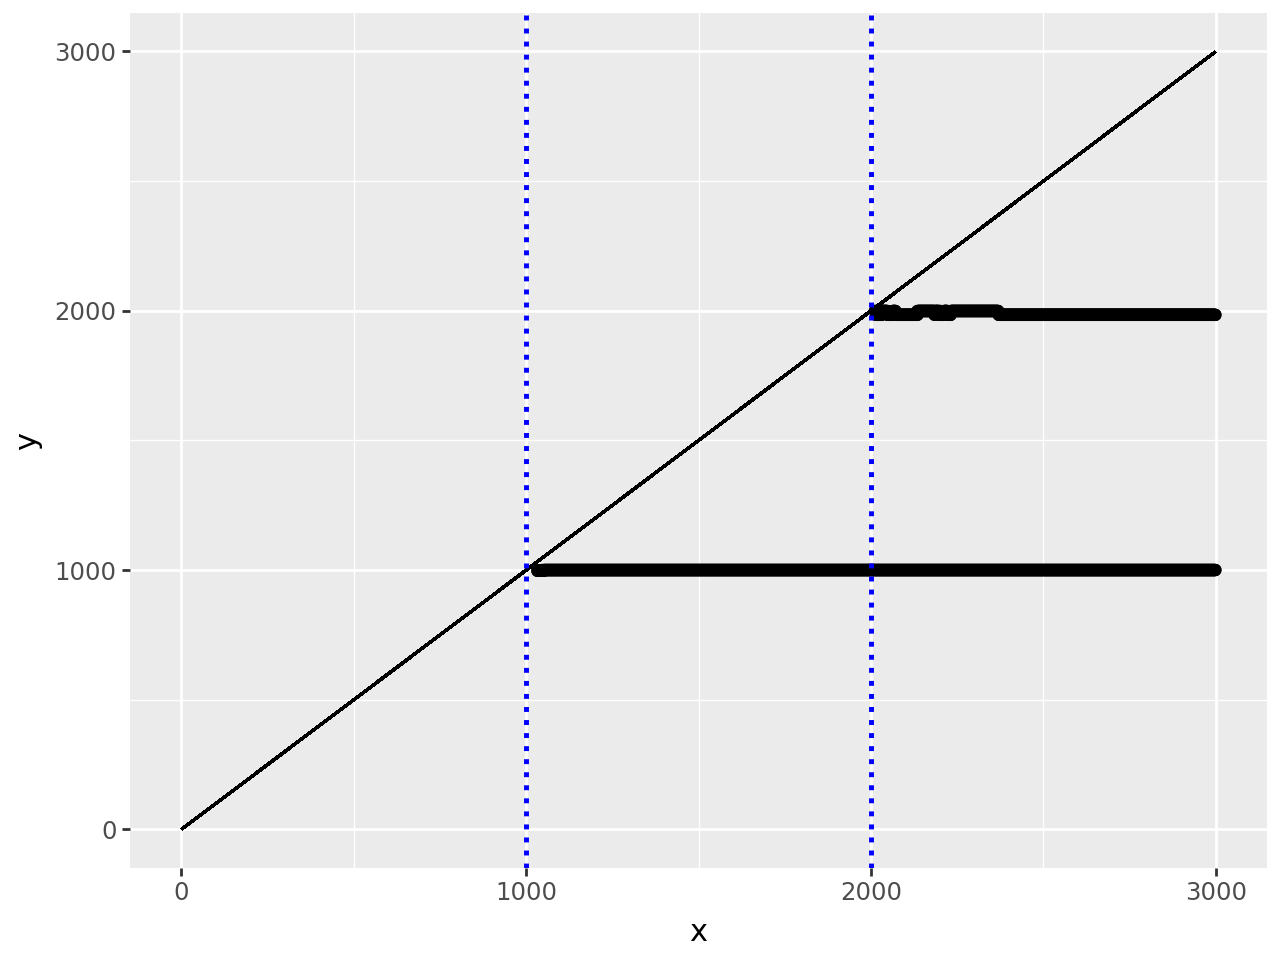

In [83]:
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

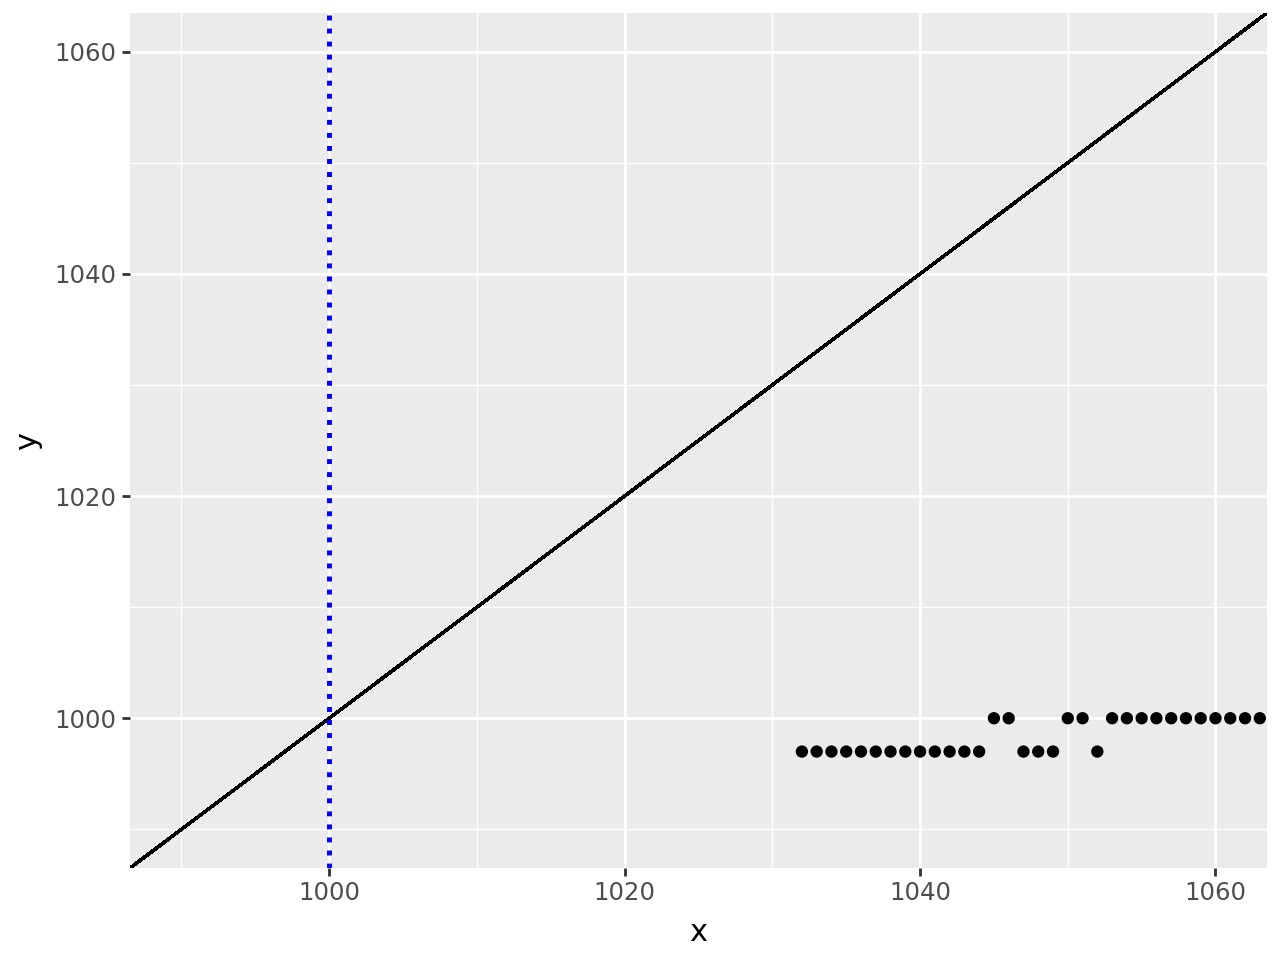

In [84]:
p + coord_cartesian(xlim=(990, 1060),ylim=(990,1060))

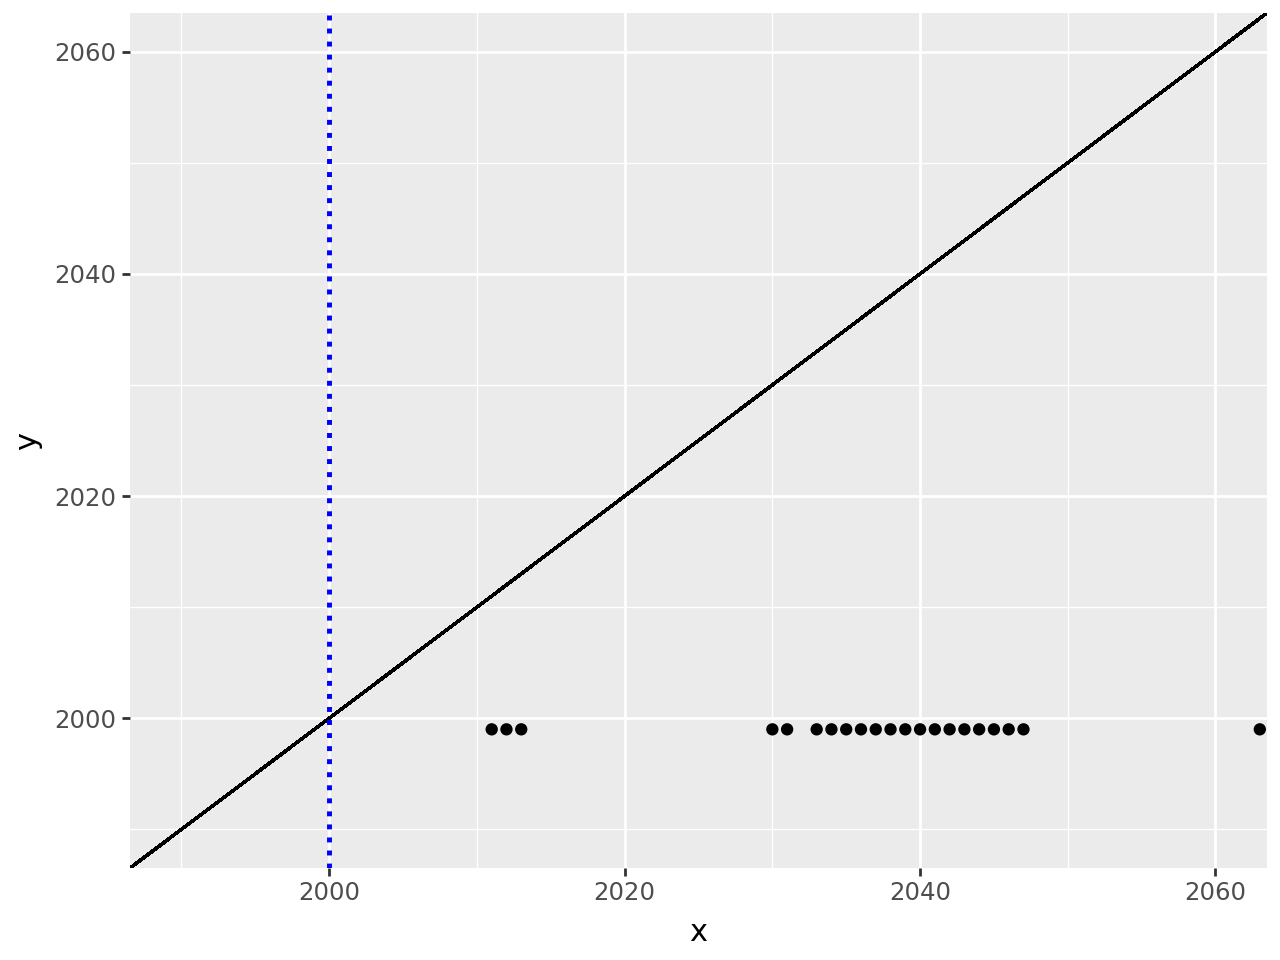

In [85]:
p + coord_cartesian(xlim=(1990, 2060),ylim=(1990,2060))

## Transform data as window grows

In [86]:
from scipy.stats import median_abs_deviation as mad
from statistics import median

In [87]:
n = len(data)
C = normal_mean(n)
F = cpts(n)
penalty = 2*log(n)
tracker = list()
X = list()
pos = 0
for z in data :
    if len(X) < 10 :
        X.append(z)
    else : 
        X.append((z-median(X))/(1.48*mad(X)))
    C.push(X[-1])
    F = op(C,F,penalty)
    tracker.append(([pos],locations(F)))
    pos += 1

In [88]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))

In [89]:
df = pd.DataFrame({"x" : res[0],"y" : res[1]})

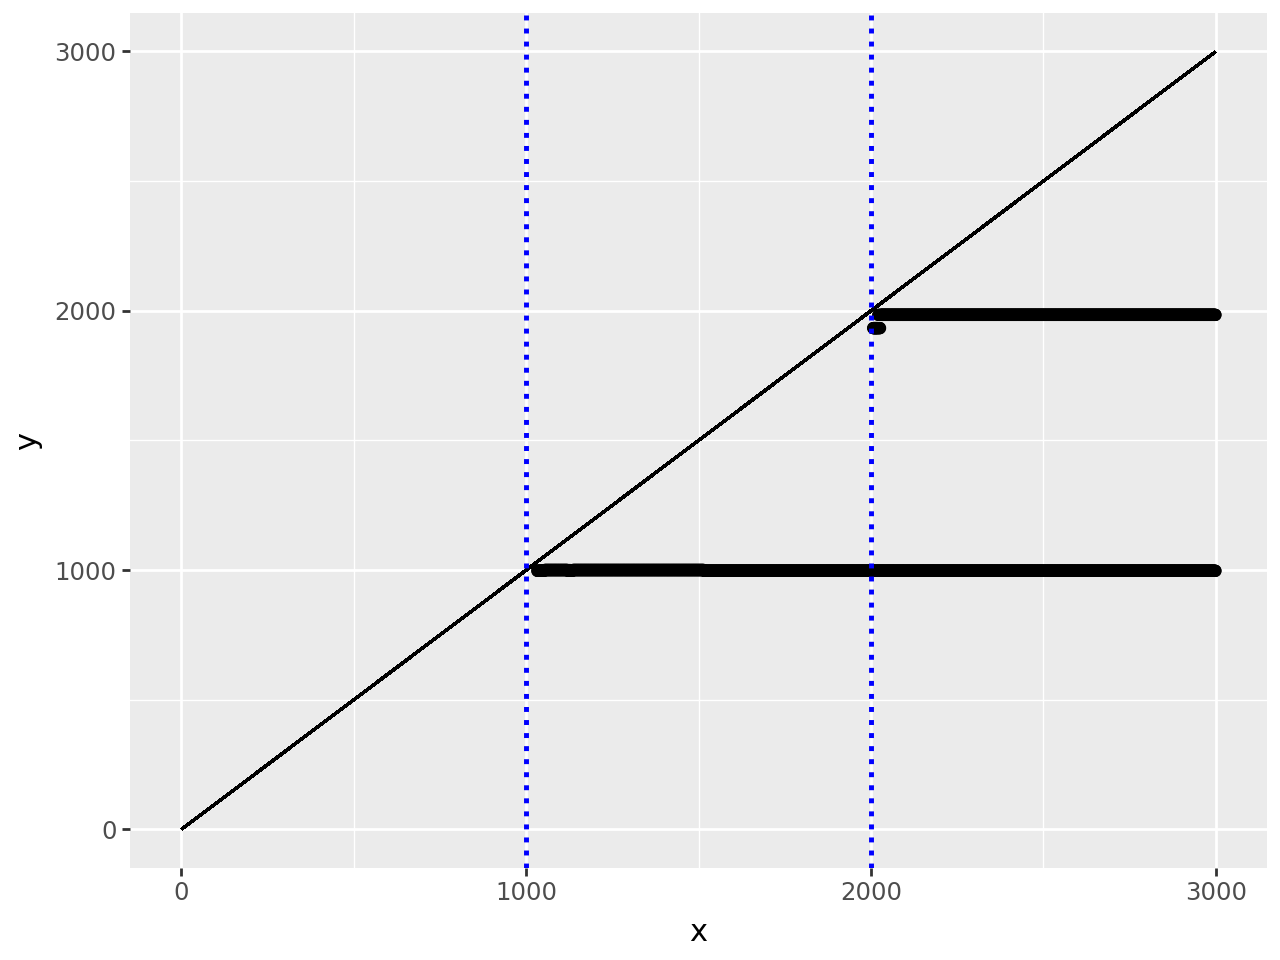

In [90]:
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

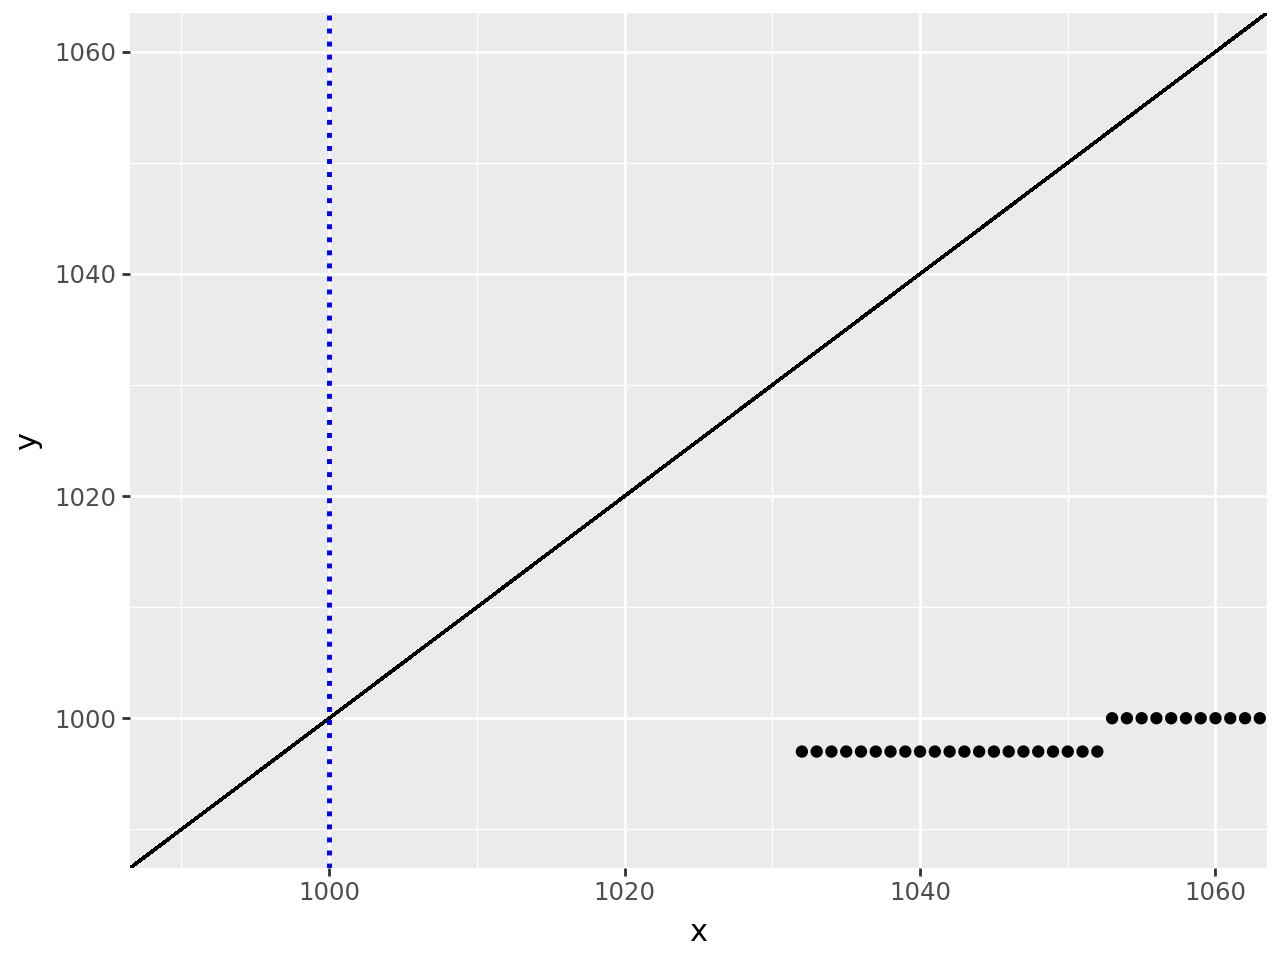

In [91]:
p + coord_cartesian(xlim=(990, 1060),ylim=(990,1060))

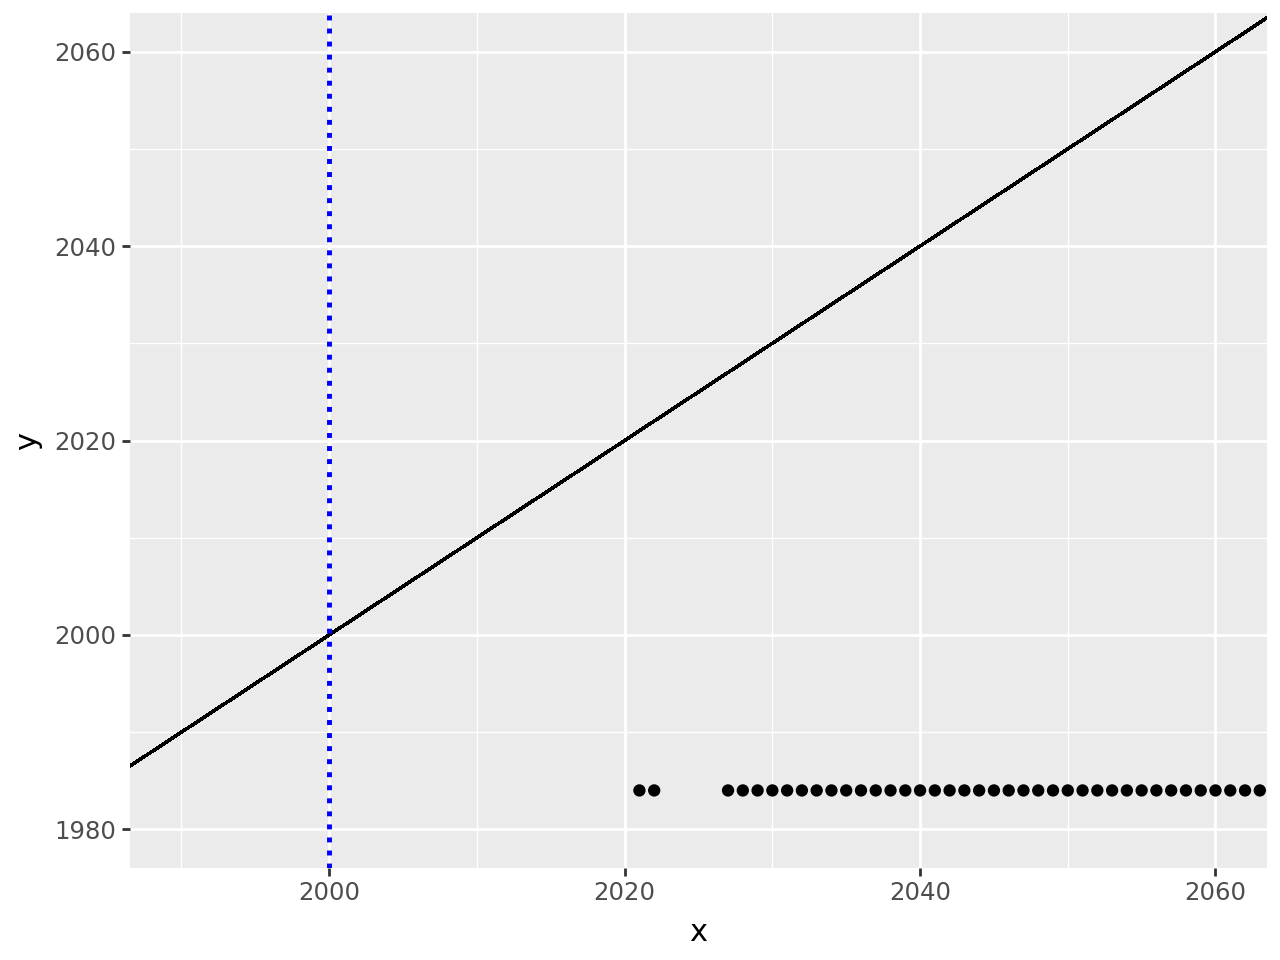

In [92]:
p + coord_cartesian(xlim=(1990, 2060),ylim=(1980,2060))

## Moving window across pre-transformed data

**Note** - does not work well as changepoints everywhere after first change - suggests a problem not transforming on the window

In [103]:
n = len(data)
wsize = 800
C = normal_mean(wsize)
F = cpts(wsize)
penalty = 2*log(wsize)
tracker = list()
X = list()
pos = 0
for z in data :
    C.push(z)
    F = op(C,F,penalty)
    if pos < wsize :
        tracker.append(([pos],locations(F)))
    else :
        locs = [pos - wsize + f for f in locations(F)]
        tracker.append(([pos],locs))
    pos += 1

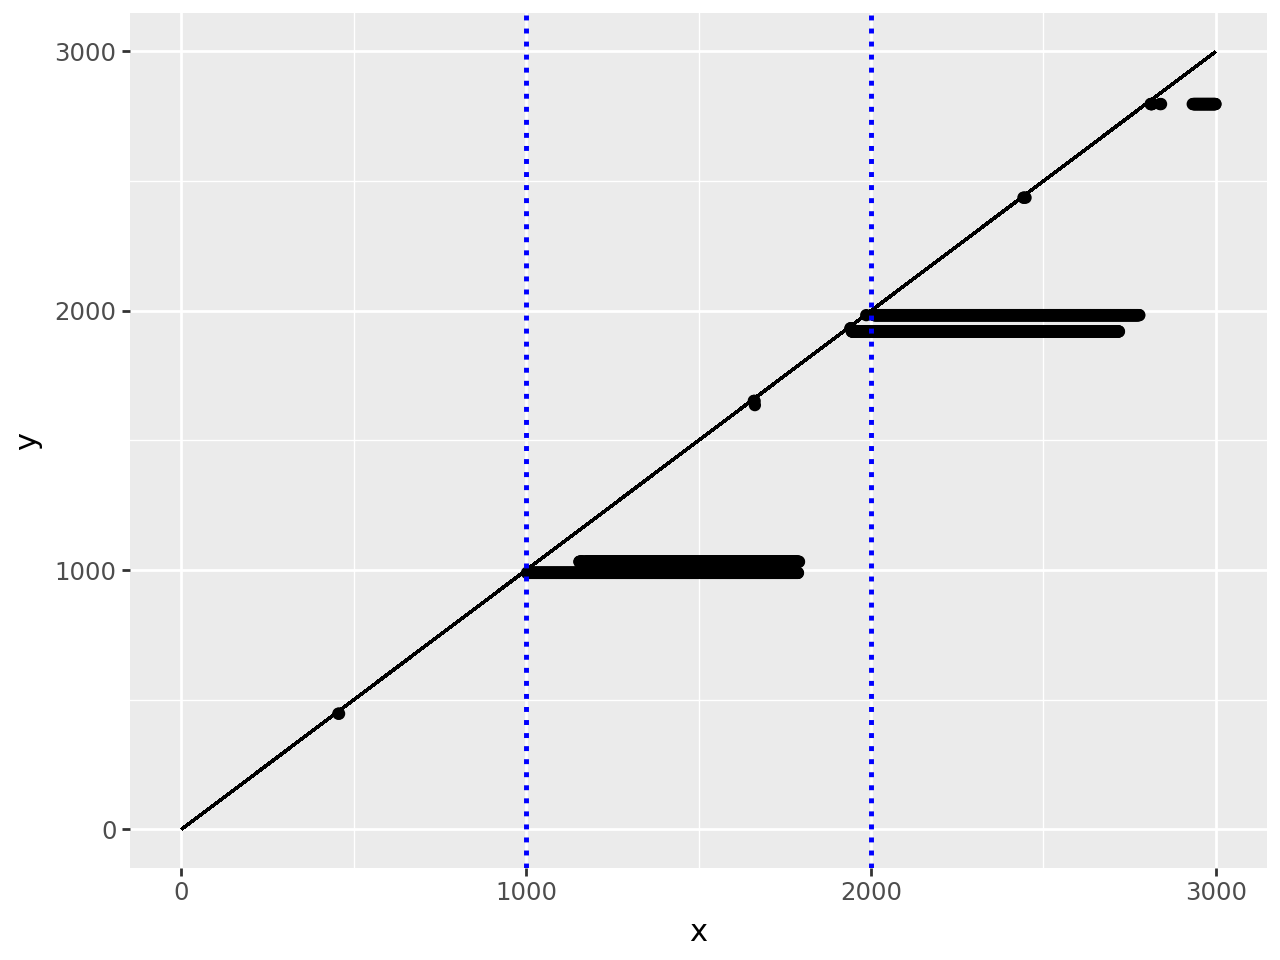

In [104]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))
df = pd.DataFrame({"x" : res[0],"y" : res[1]})
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

In [38]:
tracker[-1]

([2999], [1000, 1295, 1984])

## Moving window with transformed data

In [95]:
n = len(data)
wsize = 800
C = normal_mean(wsize)
F = cpts(wsize)
penalty = 2*log(wsize)
tracker = list()
X = deque(maxlen = wsize)
pos = 0
for z in data :
    if len(X) < 10 :
        X.append(z)
    else : 
        X.append((z-median(X))/(1.48*mad(X)))
    C.push(X[-1])
    F = op(C,F,penalty)
    if pos < wsize :
        tracker.append(([pos],locations(F)))
    else :
        locs = [pos - wsize + f for f in locations(F)]
        tracker.append(([pos],locs))
    pos += 1

In [110]:
F(499)

(np.float64(548.5160859814448), 499)

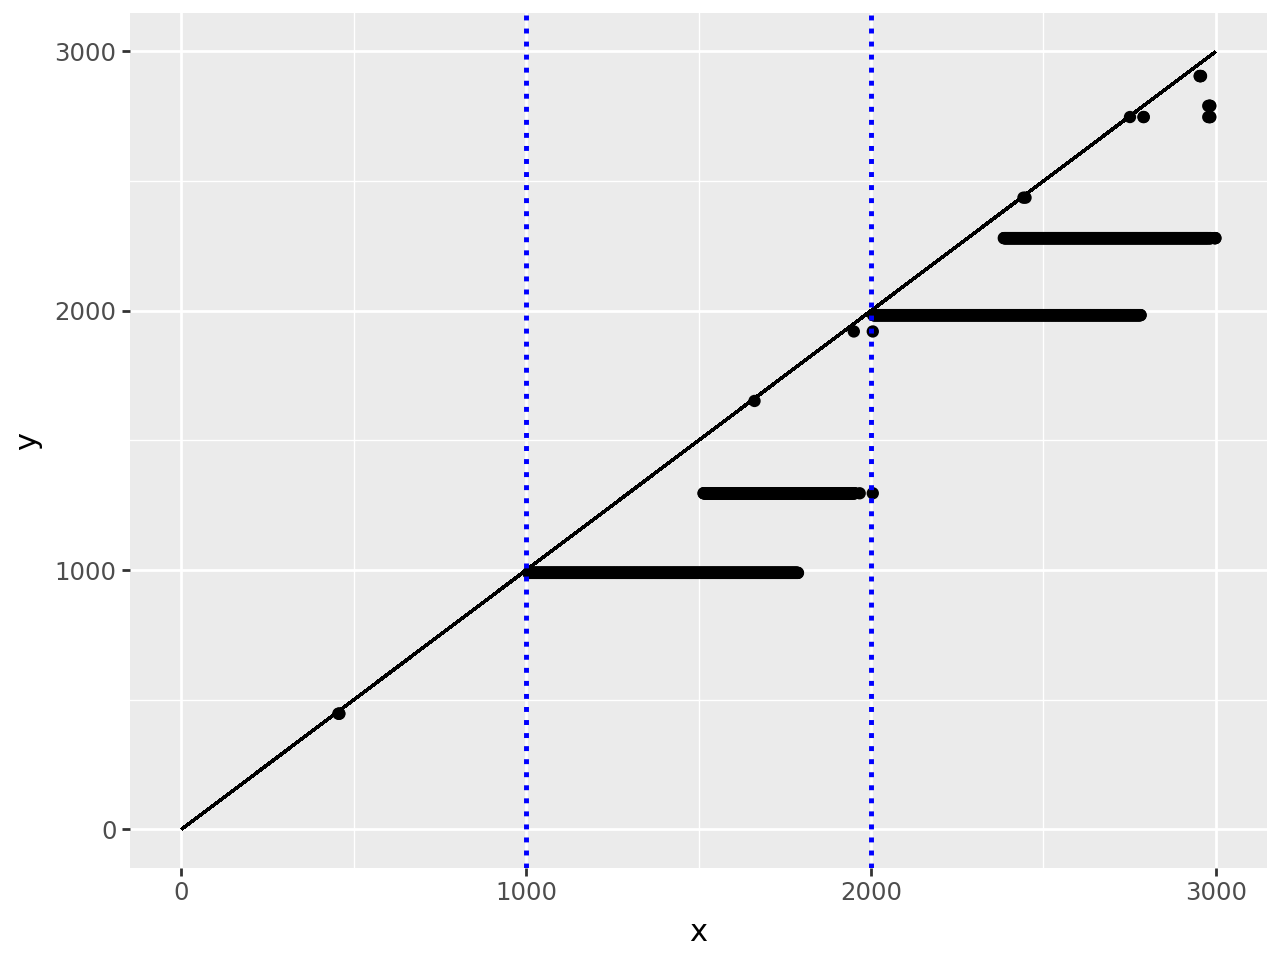

In [96]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))
df = pd.DataFrame({"x" : res[0],"y" : res[1]})
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

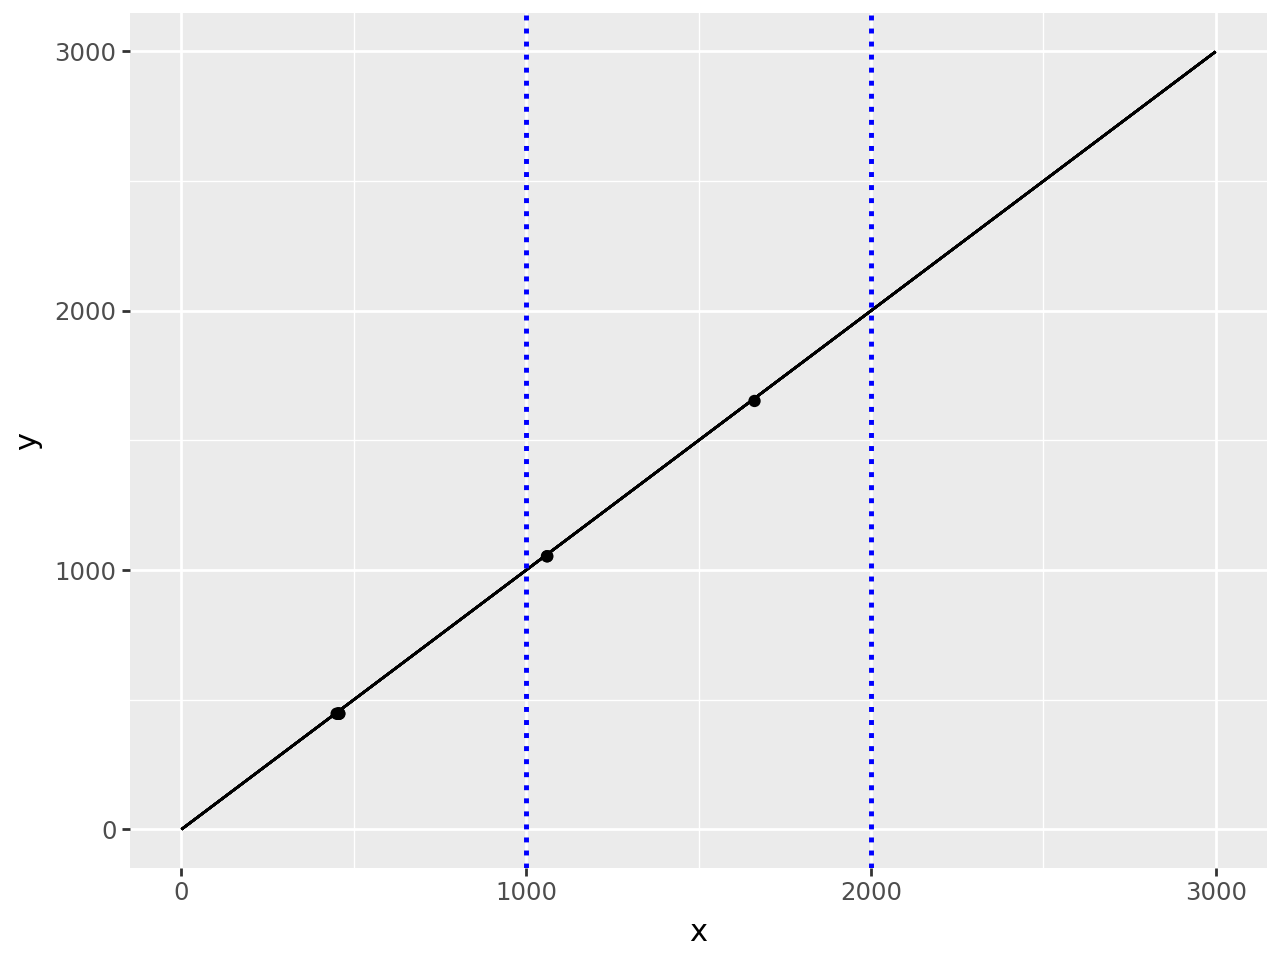

In [60]:
F(499)

(np.float64(460.2723066598298), 499)

In [40]:
## Have a look at data transformed as window eveolves

In [62]:
import matplotlib.pyplot as plt

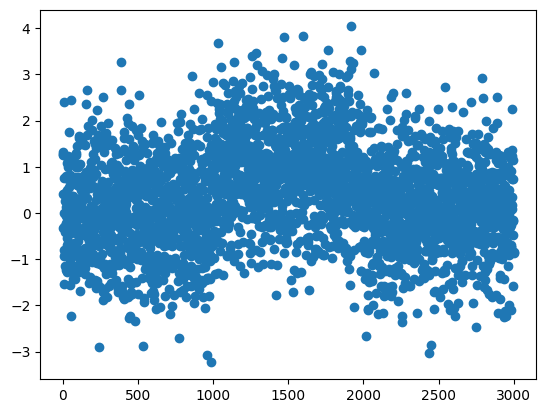

In [83]:
plt.scatter(list(range(len(data))),data)
plt.show()

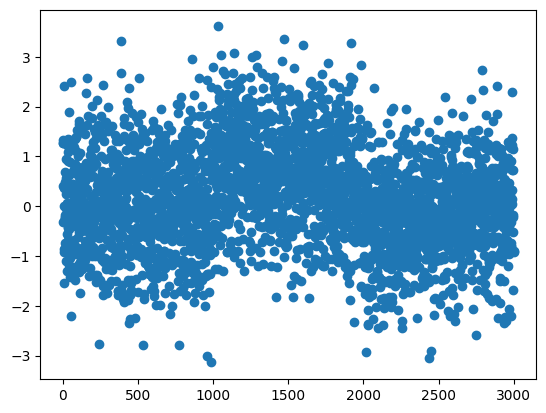

In [84]:
plt.scatter(list(range(len(XX))),list(XX))
plt.show()

In [106]:
XXX = data[750:1250]
n = len(XXX)
wsize = n
C = normal_mean(wsize)
F = cpts(wsize)
penalty = 2*log(wsize)
tracker = list()
pos = 0
for z in XXX :
    C.push(z)
    F = op(C,F,penalty)
    tracker.append(([pos],locations(F)))
    pos += 1

In [107]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))

In [108]:
df = pd.DataFrame({"x" : res[0],"y" : res[1]})

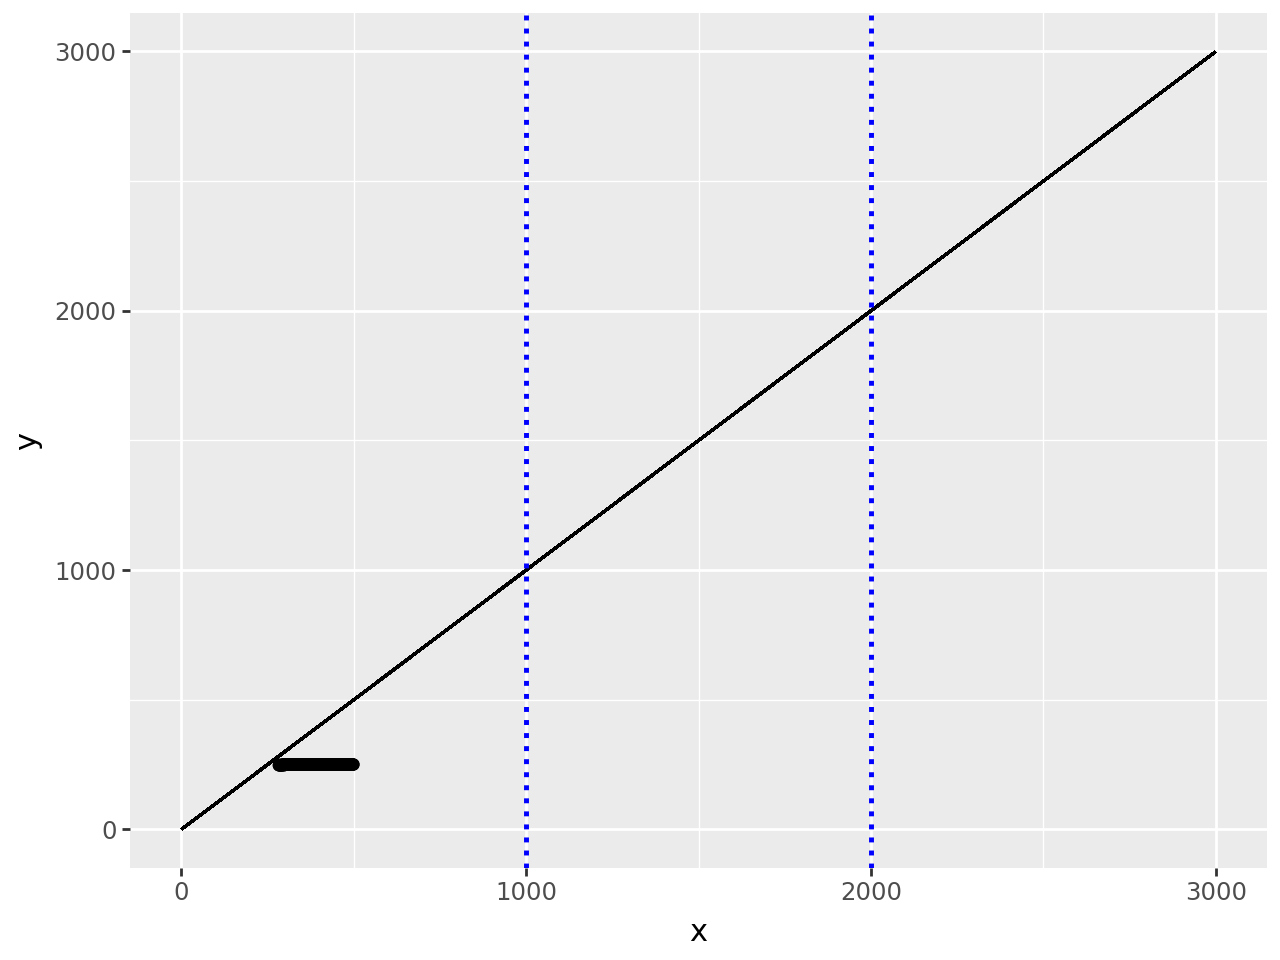

In [105]:
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

In [124]:
n = len(data)
wsize = 1500
C = normal_mean(wsize)
F = cpts(wsize)
penalty = 2*log(n)
tracker = list()
X = deque(maxlen = wsize)
pos = 0
for z in data :
    C.push(z)
    F = op(C,F,penalty)
    if pos < wsize :
        tracker.append(([pos],locations(F)))
    else :
        locs = [pos - wsize + f for f in locations(F)]
        tracker.append(([pos],locs))
    pos += 1

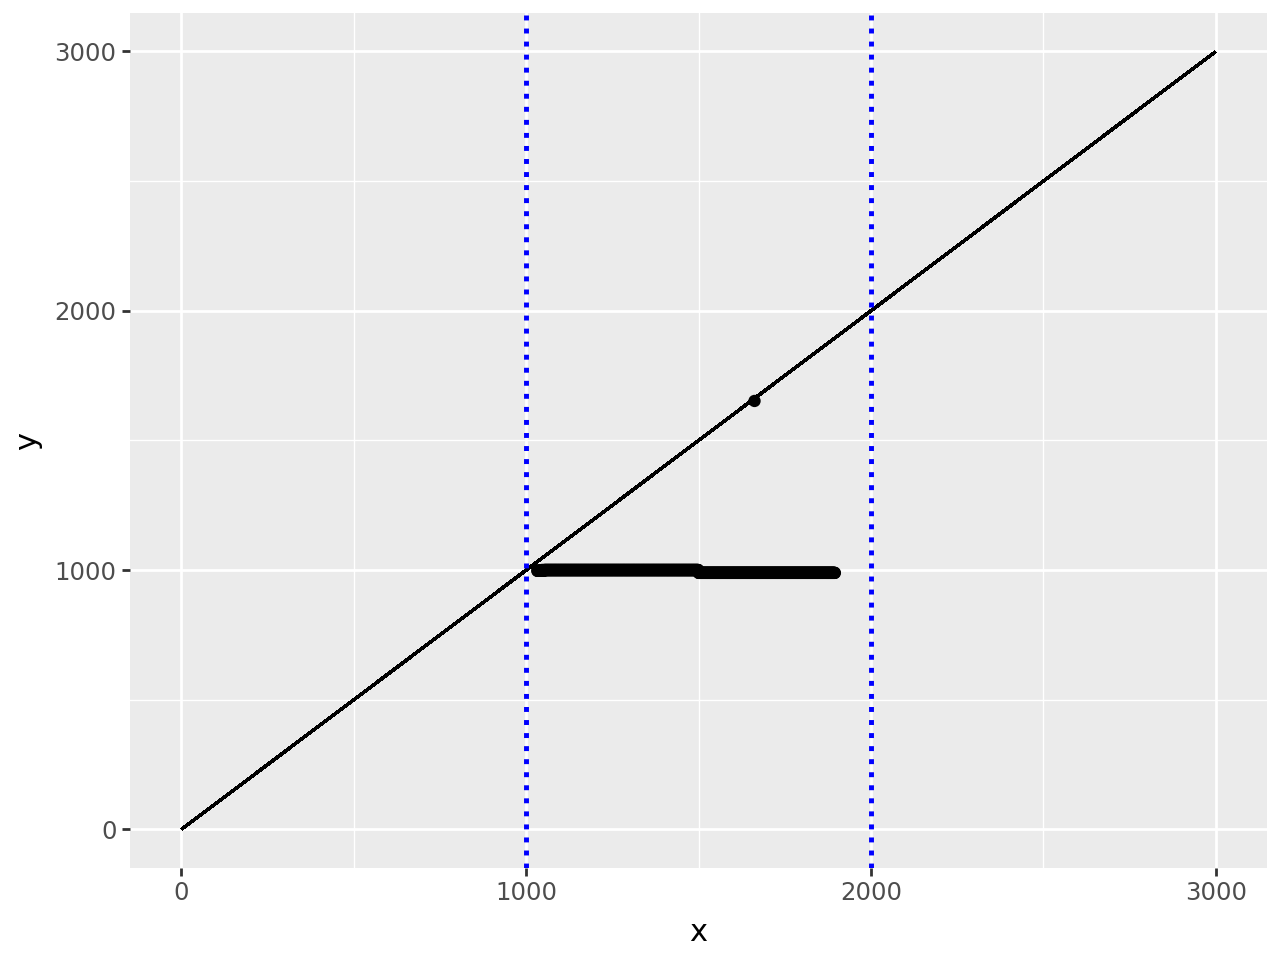

In [125]:
res = list(zip(*reduce(lambda a,b : a+b ,[list(zip(cycle(x),ys))  for x,ys in tracker])))
df = pd.DataFrame({"x" : res[0],"y" : res[1]})
p = ggplot(df, aes("x", "y")) 
p = p + geom_point()
p = p + geom_segment(aes(x = 0, y = 0, xend = 2999, yend = 2999))
p = p + geom_vline(xintercept = 1000, linetype="dotted", color = "blue", size=1)
p = p + geom_vline(xintercept = 2000, linetype="dotted", color = "blue", size=1)
p

In [126]:
F(1499)

(1770.511789098823, 1499)